# Prepare

In [22]:
import numpy as np
import torch
from glob import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

def softmax(x):
    # x has shape [batch_size, n_classes]
    x = x - np.tile(np.max(x, axis=1).reshape((-1,1)), x.shape[1])
    
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

import json
with open('../data/lemma_docids.json', 'r') as fp:
    texts = json.load(fp)

decoder = np.load('../npy/decoder.npy', allow_pickle=True).item()


# Show Topics

In [1]:
# load recent model
model_list = glob(os.path.join('../checkpoint', '*.pt'))
model_list2 = []
if not len(model_list) == 0:
    for m in model_list:
        model_list2.append((m, int(m.split('/')[-1].split('_')[0])))
    # [('../checkpoint/5_epoch_model_state.pt', 5)]
    model_list2 = sorted(model_list2, key=lambda x:x[1])


    start_epoch = model_list2[-1][1] + 1

    # load '../checkpoint/5_epoch_model_state.pt'
    state = torch.load(model_list2[-1][0], map_location=lambda storage, loc: storage)
    print(f" [*] Load SUCCESS: {model_list2[-1][0]}")

    
n_topics = state['topics.topic_vectors'].shape[0]
doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()

# distribution over the topics for each document
topic_dist = softmax(doc_weights)

similarity = np.matmul(topic_vectors, word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    #print('topic', j + 1, ':', topic_words)

print(doc_weights.shape)
print(topic_vectors.shape)
print(word_vectors.shape)
print(word_vectors[0])

NameError: name 'glob' is not defined

# Topic distribution over epochs

### As training goes on, document weight vector becomes sparser.

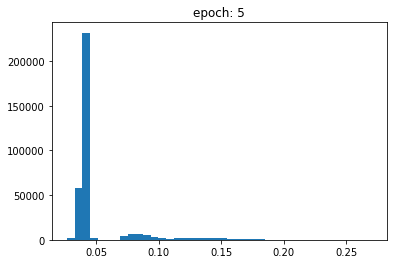

In [24]:
for each, epoch in model_list2[:-1:(len(model_list2)//10)+1][:2] + [model_list2[-1]]:
    state = torch.load(f'{each}', map_location=lambda storage, loc: storage)
    doc_weights = state['doc_weights.weight'].cpu().clone().numpy()

    # distribution over the topics for each document
    topic_dist = softmax(doc_weights)

    # distribution of nonzero probabilities
    dist = topic_dist.reshape(-1)
    plt.hist(dist[dist > 0.01], bins=40);
    plt.title(f'epoch: {epoch}')
    plt.show()
    

# Correlation of topic assignments

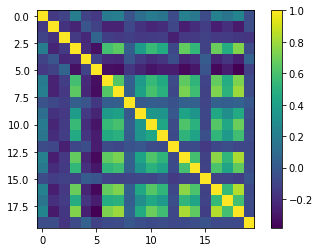

In [25]:
corr = np.corrcoef(topic_dist.transpose(1, 0))
plt.imshow(corr);
plt.colorbar();


# Show a document and its topics

In [26]:
targetTopic = 20

prominentTopicWithInd = [(i[0], i[1]) for i in zip(np.argmax(topic_dist, axis=1), range(len(texts)))]
possibleI = [i[1] for i in filter(lambda x: x[0] == targetTopic-1, prominentTopicWithInd)]
print(f'# of targetTopic docs: {len(possibleI)}. (total {len(texts)})\n')
i = np.random.choice(possibleI)

print(f'DOCUMENT index: {i}')
print(texts[i][1], '\n')

print('DISTRIBUTION OVER TOPICS:')
s = ''
for j, p in enumerate(topic_dist[i], 1):
    s += '{0}:{1:.3f}  '.format(j, p)
    if j%6 == 0:
        s += '\n'
print(s)


print('\nTOP TOPICS:')
for j in reversed(topic_dist[i].argsort()[-3:]):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words, ',', topic_dist[i][j])

# of targetTopic docs: 0. (total 222523)



ValueError: 'a' cannot be empty unless no samples are taken

# Word Vectors

In [27]:
word_vectors_norm = word_vectors / np.linalg.norm(word_vectors, axis=-1)[:, None]
rev_decoder = {v: k for k,v in decoder.items()}
vocab = [i for i,j in sorted(rev_decoder.items(), key=lambda x:x[1])]

def get_vector(token):
    index = vocab.index(token)
    return word_vectors_norm[index, :].copy()

def most_similar_func(token, n=20):
    word_vector = get_vector(token)
    similarities = np.dot(word_vectors, word_vector)
    top = np.argsort(similarities)[::-1][:n]
    return [vocab[i] for i in top]

# This is Levy & Goldberg's 3Cosmul Metric
# Based on the Gensim implementation: https://github.com/piskvorky/gensim/blob/master/gensim/models/word2vec.py
def cosmul(positives, negatives, topn=20):
    positive = [get_vector(p) for p in positives]
    negative = [get_vector(n) for n in negatives]
    pos_dists = [((1 + np.dot(word_vectors_norm, term)) / 2.) for term in positive]
    neg_dists = [((1 + np.dot(word_vectors_norm, term)) / 2.) for term in negative]
    dists = np.prod(pos_dists, axis=0) / (np.prod(neg_dists, axis=0) + 1e-6)
    idxs = np.argsort(dists)[::-1][:topn]
    return [vocab[i] for i in idxs if (vocab[i] not in positives) and (vocab[i] not in negatives)]

def most_similar_posneg(positives, negatives, topn=20):
    positive = np.sum([get_vector(p) for p in positives], axis=0)
    negative = np.sum([get_vector(n) for n in negatives], axis=0)
    vector = positive - negative
    dists = np.dot(word_vectors_norm, vector)
    idxs = np.argsort(dists)[::-1][:topn]
    return [vocab[i] for i in idxs if (vocab[i] not in positives) and (vocab[i] not in negatives)]
            

In [28]:
cosmul(['attack_nn'], [], topn=20)

['levant',
 'educa',
 'leviston',
 'beneficially',
 'pocket',
 'marriage',
 'development',
 'stout',
 'twa',
 'sink',
 'christ',
 'outdo',
 'infraction',
 'contriver',
 'march',
 'palm-leaf',
 'tophet',
 'thermal',
 'trade']

In [ ]:
['wait',
 'step',
 'assume',
 'demand',
 'sea',
 'stop',
 'indicate',
 'gay',
 'de',
 'utterly',
 'fair',
 'embrace',
 'tear',
 'fate',
 'usually',
 'melancholy',
 'style',
 'pale',
 'enjoy']